## ARIMA

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

#### Declare some visual functions

In [6]:
def plot_actual_vs_predicted(X_validation, y_actual, y_pred, feature, xlabel, ylabel):
    """
    Draw a scatter plot comparing actual and predicted values for a specific feature.

    Parameters:
    X_validation (pd.DataFrame): Input data containing the feature to be plotted.
    y_actual (array-like): Actual value.
    y_pred (array-like): Predicted value.
    feature (str): Column name in X_validation to compare.
    xlabel (str): Label for the X-axis (name of the feature displayed on the chart).
    ylabel (str): Label for the Y-axis (e.g. Price, Area, ...).
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(X_validation[feature], y_actual, c='r', marker='o', label="Actual values", alpha=0.5) 
    plt.scatter(X_validation[feature], y_pred, c='b', marker='s', label="Predicted values", alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(f"Scatter Plot of Actual vs Predicted {ylabel} per {xlabel}")
    plt.show()


#### Select feature

##### Read data

- Practice training

In [7]:
df = pd.read_csv("TransformedData.csv")
df.head()

,Posted Time,District Name,Price per m2
0,2024-12-01,Huyện Hòa Vang,0.103732
1,2024-12-02,Huyện Hòa Vang,0.103732
2,2024-12-03,Huyện Hòa Vang,0.103732
3,2024-12-04,Huyện Hòa Vang,0.103732
4,2024-12-05,Huyện Hòa Vang,0.103227


##### Input variables

In [8]:
if not pd.api.types.is_datetime64_any_dtype(df['Posted Time']):
    df['Posted Time'] = pd.to_datetime(df['Posted Time'])
districts = df['District Name'].unique()
print(f"Các quận/huyện trong dữ liệu: {districts}")

Các quận/huyện trong dữ liệu: ['Huyện Hòa Vang' 'Quận Cẩm Lệ' 'Quận Hải Châu' 'Quận Liên Chiểu'
 'Quận Ngũ Hành Sơn' 'Quận Sơn Trà' 'Quận Thanh Khê']


##### Target variables

In [9]:
# Bước 4: Chia dữ liệu thành tập huấn luyện và tập kiểm tra cho từng quận
def split_train_test(data, test_size=0.2):
    # Dictionary lưu trữ dữ liệu đã chia của các quận
    district_data = {}
    
    for district in districts:
        # Lọc dữ liệu cho quận cụ thể
        district_df = data[data['District Name'] == district].copy()
        
        # Sắp xếp dữ liệu theo thời gian
        district_df = district_df.sort_values('Posted Time')
        
        # Chuẩn bị chuỗi thời gian
        time_series = district_df.set_index('Posted Time')['Price per m2']
        
        # Chia dữ liệu thành tập train và test
        train_size = int(len(time_series) * (1 - test_size))
        train_ts = time_series[:train_size]
        test_ts = time_series[train_size:]
        
        # Lưu vào dictionary
        district_data[district] = {
            'full_ts': time_series,
            'train_ts': train_ts,
            'test_ts': test_ts,
            'train_raw': district_df.iloc[:train_size],
            'test_raw': district_df.iloc[train_size:]
        }
    
    return district_data

##### Divide into 2 training sets and validation sets

 - Split data

In [10]:
# Bước 5: Thực hiện chia dữ liệu
district_datasets = split_train_test(df, test_size=0.2)

In [11]:
# Bước 6: Hàm kiểm tra tính dừng của chuỗi thời gian (stationarity)
def check_stationarity(time_series, district):
    """
    Kiểm tra tính dừng của chuỗi thời gian bằng Augmented Dickey-Fuller test
    
    Parameters:
    time_series (Series): Chuỗi thời gian cần kiểm tra
    district (str): Tên quận
    
    Returns:
    dict: Kết quả kiểm tra
    """
    # Thực hiện ADF test
    result = adfuller(time_series.dropna())
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(time_series)
    plt.title(f'Chuỗi thời gian giá bất động sản tại {district}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (đơn vị/m2)')
    plt.grid(True)
    plt.show()
    
    # Rolling statistics
    plt.figure(figsize=(12, 6))
    rolling_mean = time_series.rolling(window=7).mean()
    rolling_std = time_series.rolling(window=7).std()
    
    plt.plot(time_series, label='Dữ liệu gốc')
    plt.plot(rolling_mean, label='Trung bình trượt (7 ngày)')
    plt.plot(rolling_std, label='Độ lệch chuẩn trượt (7 ngày)')
    plt.legend()
    plt.title(f'Phân tích trượt cho chuỗi thời gian tại {district}')
    plt.grid(True)
    plt.show()
    
    # ADF test results
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    
    if result[1] <= 0.05:
        print("Chuỗi thời gian đã dừng (stationary)")
        diff_order = 0
    else:
        print("Chuỗi thời gian chưa dừng (non-stationary)")
        diff_order = 1  # Đề xuất sử dụng d=1 cho ARIMA
    
    return {
        'adf_statistic': result[0],
        'p_value': result[1],
        'diff_order': diff_order
    }

In [12]:
# Bước 7: Xác định thông số ARIMA cho từng quận
def determine_arima_params(district, time_series):
    """
    Xác định các thông số cho mô hình ARIMA
    
    Parameters:
    district (str): Tên quận
    time_series (Series): Chuỗi thời gian
    
    Returns:
    tuple: Các tham số (p, d, q) cho ARIMA
    """
    print(f"Xác định thông số ARIMA cho {district}")
    
    # Kiểm tra tính dừng
    stationarity_check = check_stationarity(time_series, district)
    d = stationarity_check['diff_order']
    
    # Nếu chuỗi không dừng, thực hiện phép sai phân (differencing)
    if d > 0:
        time_series_diff = time_series.diff(d).dropna()
        print(f"Đã thực hiện sai phân bậc {d}")
        
        # Kiểm tra lại tính dừng sau khi sai phân
        diff_stationarity = check_stationarity(time_series_diff, f"{district} (sau sai phân)")
    else:
        time_series_diff = time_series
    
    # Vẽ đồ thị ACF và PACF để xác định p, q
    plt.figure(figsize=(12, 8))
    
    plt.subplot(211)
    plot_acf(time_series_diff.dropna(), ax=plt.gca(), lags=20)
    plt.title(f'ACF cho {district}')
    
    plt.subplot(212)
    plot_pacf(time_series_diff.dropna(), ax=plt.gca(), lags=20)
    plt.title(f'PACF cho {district}')
    
    plt.tight_layout()
    plt.show()
    
    # Xác định p, q dựa trên ACF và PACF
    # Đây là một cách đơn giản để ước lượng, có thể dùng phương pháp lưới hoặc AIC/BIC để tối ưu
    p = int(input(f"Nhập giá trị p cho {district} (thường là số lag có ý nghĩa trong PACF): "))
    q = int(input(f"Nhập giá trị q cho {district} (thường là số lag có ý nghĩa trong ACF): "))
    
    return (p, d, q)

#### Model training

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def auto_sarima_params(district, time_series, 
                       max_p=2, max_d=1, max_q=2,
                       max_P=1, max_D=1, max_Q=1, seasonal_period=12):
    """
    Tự động tìm tham số SARIMA tốt nhất dựa trên AIC

    Parameters:
    - district (str): Tên quận
    - time_series (Series): Chuỗi thời gian
    - max_p, max_d, max_q (int): Giá trị tối đa cho p, d, q
    - max_P, max_D, max_Q (int): Giá trị tối đa cho P, D, Q
    - seasonal_period (int): Độ dài chu kỳ (ví dụ 12 nếu là tháng, 7 nếu là tuần)

    Returns:
    tuple: Các tham số ((p,d,q), (P,D,Q,s)) tốt nhất cho SARIMA
    """
    print(f"Đang tìm tham số SARIMA tối ưu cho {district}...")

    best_aic = float('inf')
    best_params = None

    # Kiểm tra tính dừng để xác định d
    stationarity_check = check_stationarity(time_series, district)
    base_d = stationarity_check['diff_order']

    for p in range(max_p + 1):
        for d in range(base_d, base_d + 1):  # giữ nguyên d
            for q in range(max_q + 1):
                for P in range(max_P + 1):
                    for D in range(max_D + 1):
                        for Q in range(max_Q + 1):
                            try:
                                model = SARIMAX(time_series,
                                                order=(p, d, q),
                                                seasonal_order=(P, D, Q, seasonal_period),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                results = model.fit(disp=False)

                                if results.aic < best_aic:
                                    best_aic = results.aic
                                    best_params = ((p, d, q), (P, D, Q, seasonal_period))

                                    print(f"🔍 Tốt hơn: SARIMA{best_params} với AIC = {best_aic}")
                            except Exception as e:
                                continue

    print(f"✅ Tham số SARIMA tốt nhất cho {district}: {best_params}")
    return best_params


##### Correlation Coefficient and Intercept Deviation Value

In [14]:

def train_sarima_models(district_datasets, seasonal_period=12):
    """
    Huấn luyện mô hình SARIMA cho từng quận
    
    Parameters:
    - district_datasets (dict): Dictionary chứa dữ liệu chuỗi thời gian cho từng quận
    - seasonal_period (int): Độ dài chu kỳ mùa vụ (ví dụ: 12 nếu dữ liệu theo tháng và có mùa vụ theo năm)
    
    Returns:
    - dict: Dictionary chứa các mô hình SARIMA đã huấn luyện
    """
    models = {}

    for district, datasets in district_datasets.items():
        print(f"\nĐang huấn luyện SARIMA cho {district}...")
        
        train_ts = datasets['train_ts']
        
        # Chọn tham số SARIMA cơ bản (có thể dùng auto_arima nếu muốn tự động hóa)
        order = (1, 1, 1)
        seasonal_order = (1, 1, 1, seasonal_period)
        
        try:
            model = SARIMAX(train_ts,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            
            results = model.fit(disp=False)
            
            models[district] = {
                'order': order,
                'seasonal_order': seasonal_order,
                'model': results
            }
            
            print(f"Huấn luyện thành công SARIMA{order} x {seasonal_order} cho {district}")
            print(f"AIC: {results.aic}")
        
        except Exception as e:
            print(f"Lỗi khi huấn luyện mô hình cho {district}: {e}")
    
    return models


##### Real estate price prediction

- On the train set

In [15]:
district_models = train_sarima_models(district_datasets)


Đang huấn luyện SARIMA cho Huyện Hòa Vang...
Huấn luyện thành công SARIMA(1, 1, 1) x (1, 1, 1, 12) cho Huyện Hòa Vang
AIC: -531.2206595701089

Đang huấn luyện SARIMA cho Quận Cẩm Lệ...


Huấn luyện thành công SARIMA(1, 1, 1) x (1, 1, 1, 12) cho Quận Cẩm Lệ
AIC: -218.9708532049574

Đang huấn luyện SARIMA cho Quận Hải Châu...
Huấn luyện thành công SARIMA(1, 1, 1) x (1, 1, 1, 12) cho Quận Hải Châu
AIC: -265.729155282667

Đang huấn luyện SARIMA cho Quận Liên Chiểu...
Huấn luyện thành công SARIMA(1, 1, 1) x (1, 1, 1, 12) cho Quận Liên Chiểu
AIC: -355.7555003595506

Đang huấn luyện SARIMA cho Quận Ngũ Hành Sơn...
Huấn luyện thành công SARIMA(1, 1, 1) x (1, 1, 1, 12) cho Quận Ngũ Hành Sơn
AIC: -304.3534741551088

Đang huấn luyện SARIMA cho Quận Sơn Trà...
Huấn luyện thành công SARIMA(1, 1, 1) x (1, 1, 1, 12) cho Quận Sơn Trà
AIC: -256.4826129547914

Đang huấn luyện SARIMA cho Quận Thanh Khê...
Huấn luyện thành công SARIMA(1, 1, 1) x (1, 1, 1, 12) cho Quận Thanh Khê
AIC: -330.6165266598684


In [16]:
# Bước 11: Đánh giá mô hình
def evaluate_arima_model(district, model_info, datasets, forecast_steps=180):
    """
    Đánh giá mô hình ARIMA và thực hiện dự báo
    
    Parameters:
    district (str): Tên quận
    model_info (dict): Thông tin về mô hình ARIMA
    datasets (dict): Dữ liệu của quận
    forecast_steps (int): Số bước dự báo trong tương lai
    
    Returns:
    dict: Kết quả đánh giá và dự báo
    """
    # Lấy dữ liệu và mô hình
    train_ts = datasets['train_ts']
    test_ts = datasets['test_ts']
    model_results = model_info['model']
    
    # Dự báo trên tập test
    if not test_ts.empty:
        # Dự báo trong sample
        in_sample_pred = model_results.predict(start=0, end=len(train_ts)-1)
        
        # Dự báo ngoài sample (tập test)
        test_forecast = model_results.forecast(steps=len(test_ts))
        
        # Tính các chỉ số đánh giá
        test_actual = test_ts.values
        test_predicted = test_forecast
        
        # Cắt test_predicted nếu dài hơn test_actual
        if len(test_predicted) > len(test_actual):
            test_predicted = test_predicted[:len(test_actual)]
        
        # Cắt test_actual nếu dài hơn test_predicted
        if len(test_actual) > len(test_predicted):
            test_actual = test_actual[:len(test_predicted)]
        
        mae = np.mean(np.abs(test_actual - test_predicted))
        mse = np.mean((test_actual - test_predicted) ** 2)
        rmse = np.sqrt(mse)
    else:
        in_sample_pred = model_results.predict(start=0, end=len(train_ts)-1)
        test_forecast = None
        mae = mse = rmse = np.nan
    
    # Dự báo trong tương lai
    future_forecast = model_results.forecast(steps=forecast_steps)
    
    # Tạo index cho dự báo tương lai
    if not test_ts.empty:
        last_date = test_ts.index[-1]
    else:
        last_date = train_ts.index[-1]
    
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)
    future_forecast_series = pd.Series(future_forecast, index=future_dates)
    
    return {
        'district': district,
        'in_sample_pred': in_sample_pred,
        'test_forecast': test_forecast,
        'test_metrics': {
            'mae': mae,
            'mse': mse,
            'rmse': rmse
        },
        'future_forecast': future_forecast_series
    }

In [17]:
# Bước 12: Thực hiện đánh giá và dự báo cho từng quận
evaluation_results = {}
for district, model_info in district_models.items():
    result = evaluate_arima_model(district, model_info, district_datasets[district])
    evaluation_results[district] = result

In [18]:
# Bước 13: Vẽ biểu đồ dự báo cho từng quận
def plot_district_forecast(district, eval_result, datasets):
    """
    Vẽ biểu đồ dự báo giá cho một quận cụ thể
    
    Parameters:
    district (str): Tên quận
    eval_result (dict): Kết quả đánh giá và dự báo
    datasets (dict): Dữ liệu của quận
    """
    train_ts = datasets['train_ts']
    test_ts = datasets['test_ts']
    in_sample_pred = eval_result['in_sample_pred']
    test_forecast = eval_result['test_forecast']
    future_forecast = eval_result['future_forecast']
    
    # Vẽ biểu đồ
    plt.figure(figsize=(14, 8))
    
    # Vẽ dữ liệu huấn luyện
    plt.plot(train_ts.index, train_ts.values, color='black', label='Dữ liệu huấn luyện')
    
    # Vẽ dự báo trong sample
    plt.plot(train_ts.index, in_sample_pred, color='blue', linestyle='--', label='Dự báo trong sample')
    
    # Vẽ dữ liệu kiểm tra nếu có
    if test_ts is not None and not test_ts.empty:
        plt.plot(test_ts.index, test_ts.values, color='red', label='Dữ liệu kiểm tra')
        
        # Vẽ dự báo trên tập test
        if test_forecast is not None:
            plt.plot(test_ts.index[:len(test_forecast)], test_forecast, color='green', 
                    linestyle='--', label='Dự báo ngoài sample')
    
    # Vẽ dự báo tương lai
    plt.plot(future_forecast.index, future_forecast.values, color='purple', 
             linestyle='--', label='Dự báo tương lai')
    
    # Thông tin về chỉ số đánh giá
    metrics = eval_result['test_metrics']
    metrics_text = f"MAE: {metrics['mae']:.4f}, RMSE: {metrics['rmse']:.4f}"
    
    plt.title(f'Dự báo giá bất động sản tại {district} sử dụng ARIMA\n{metrics_text}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (đơn vị/m2)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    return plt

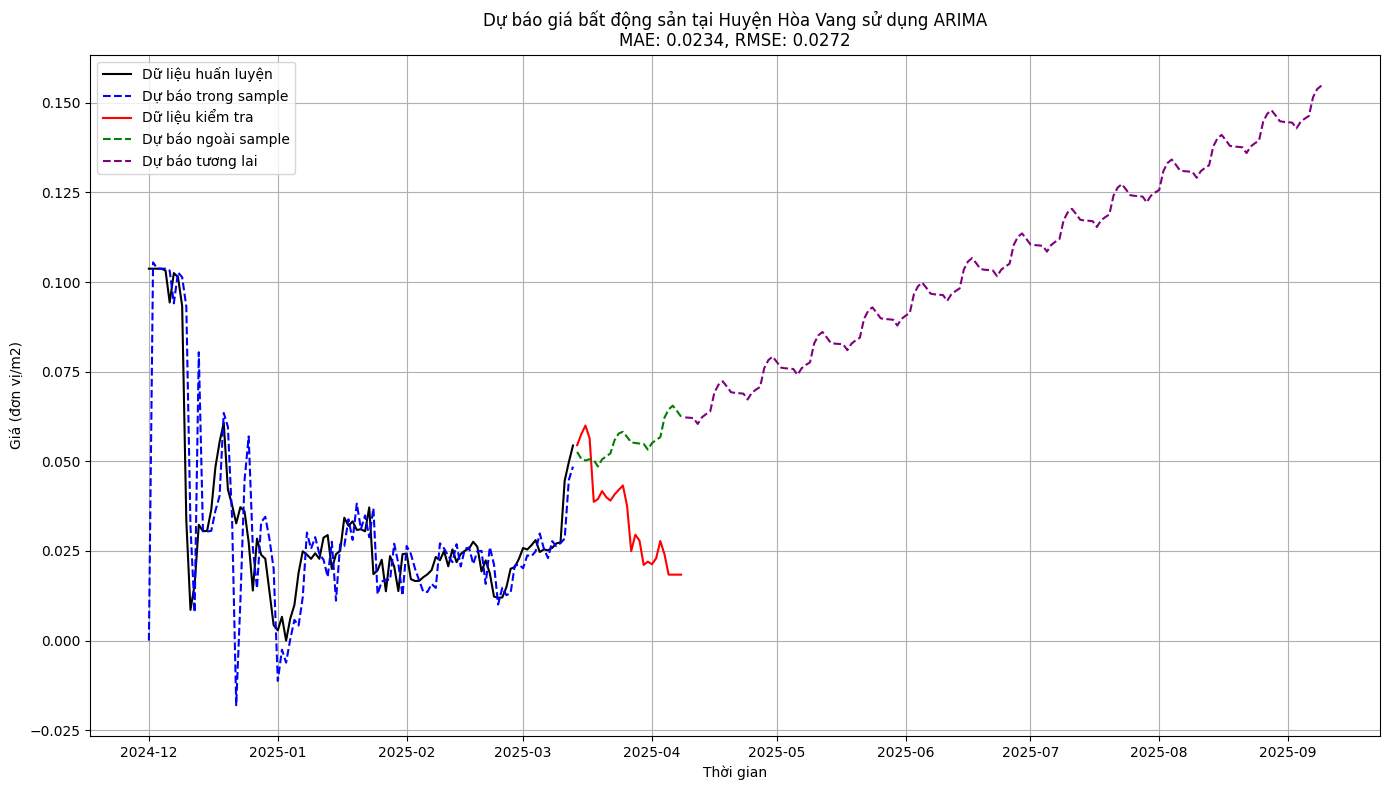

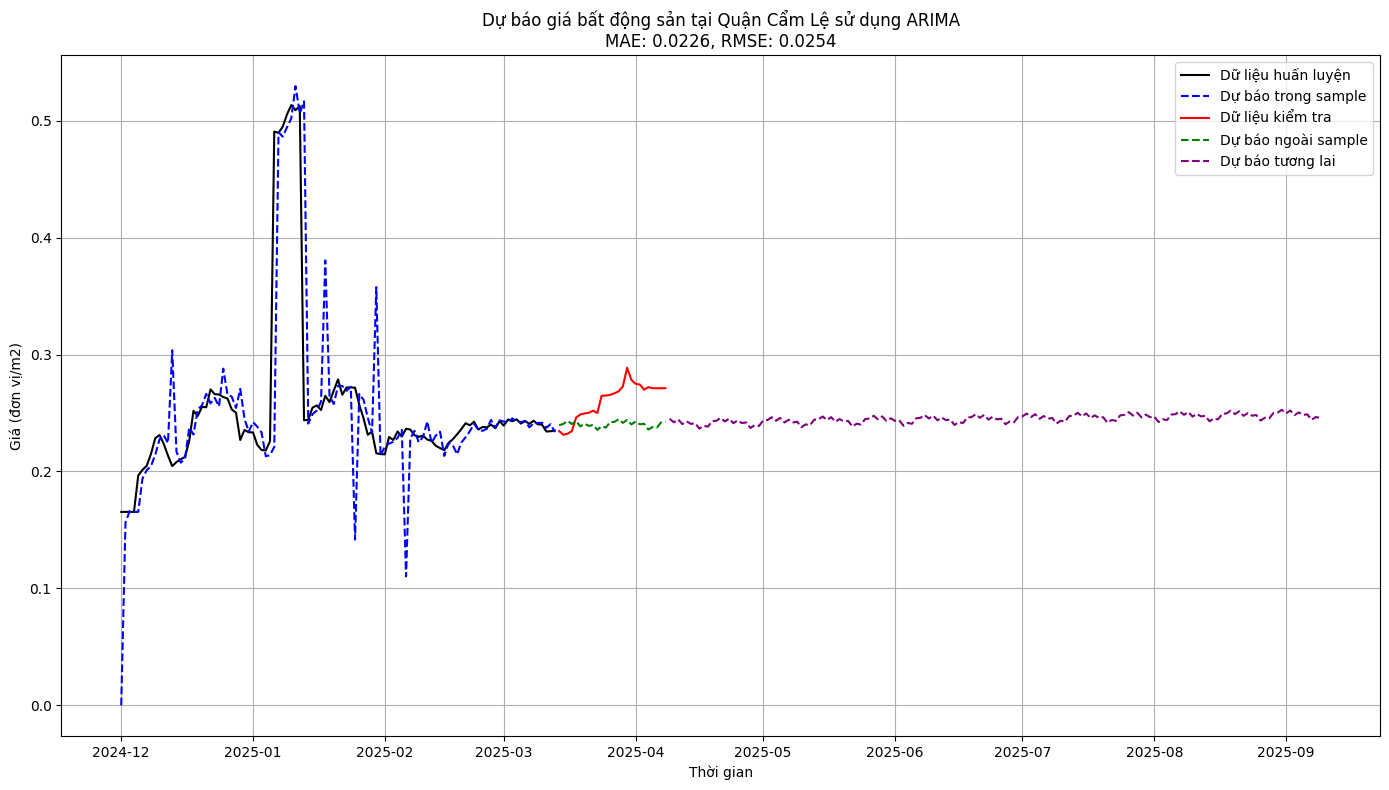

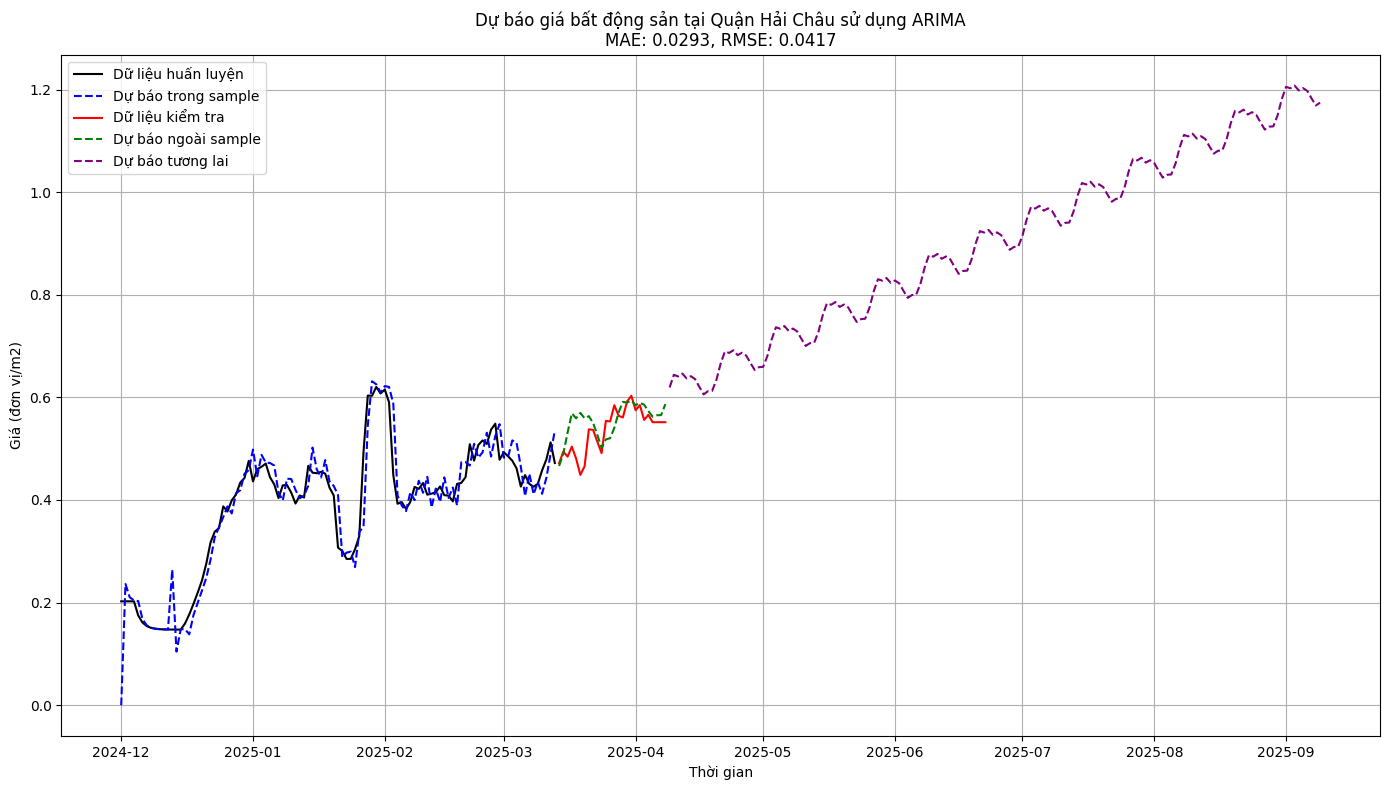

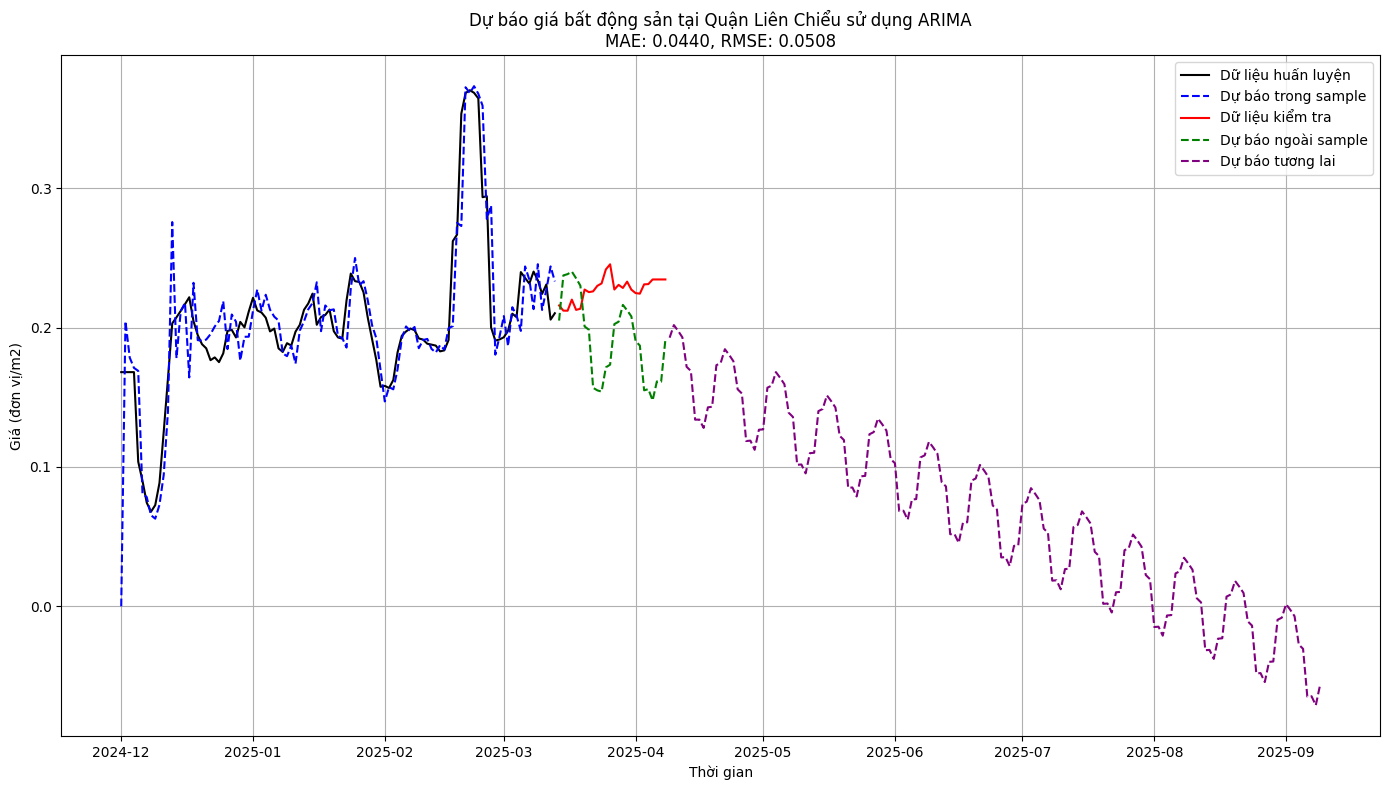

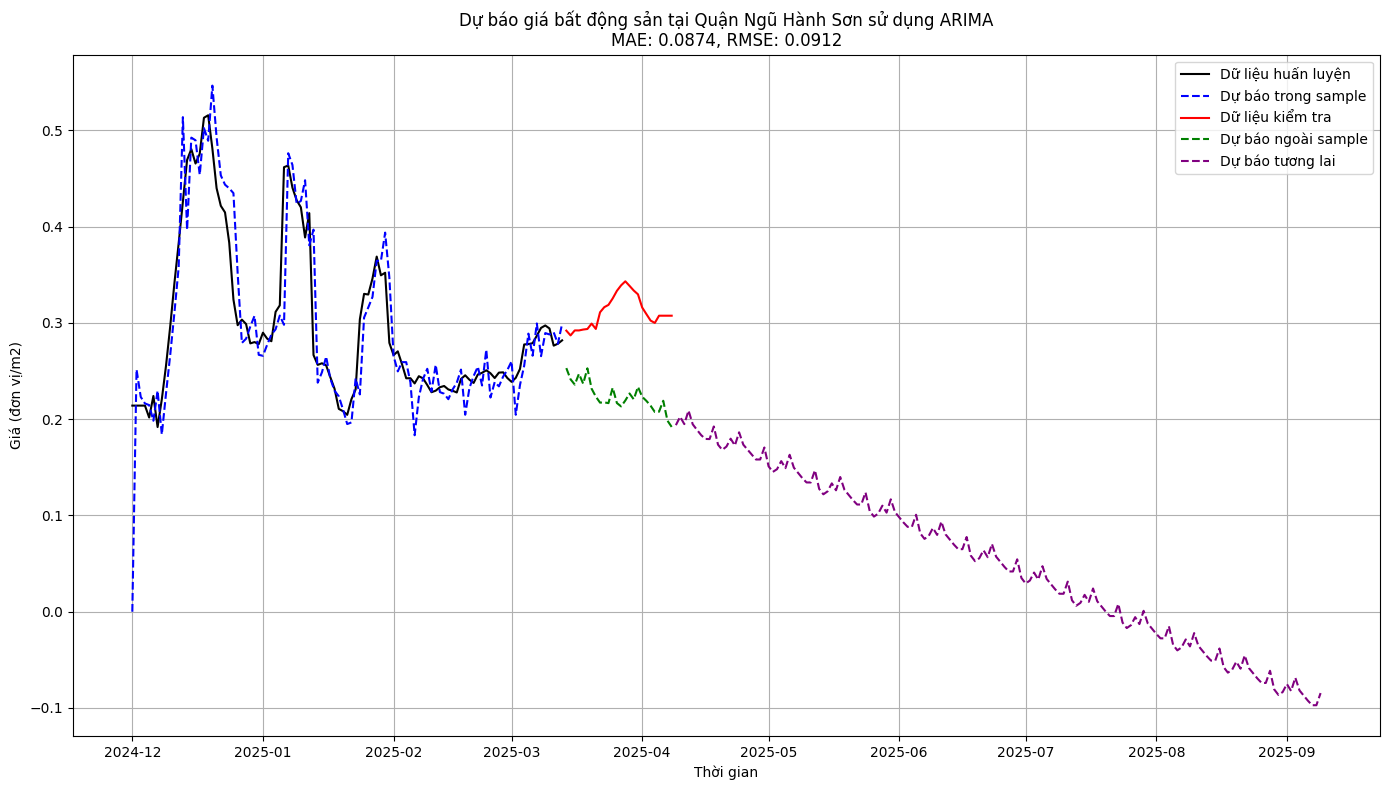

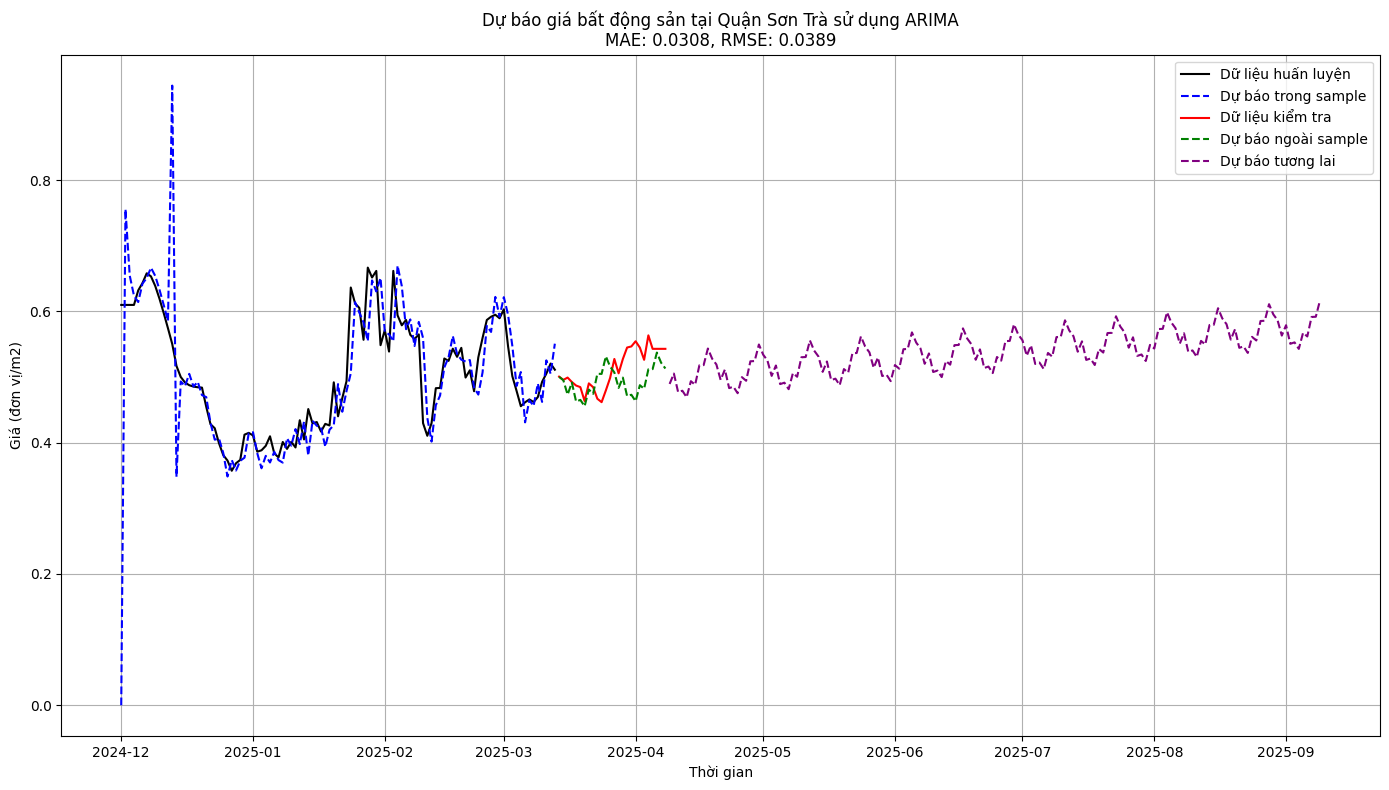

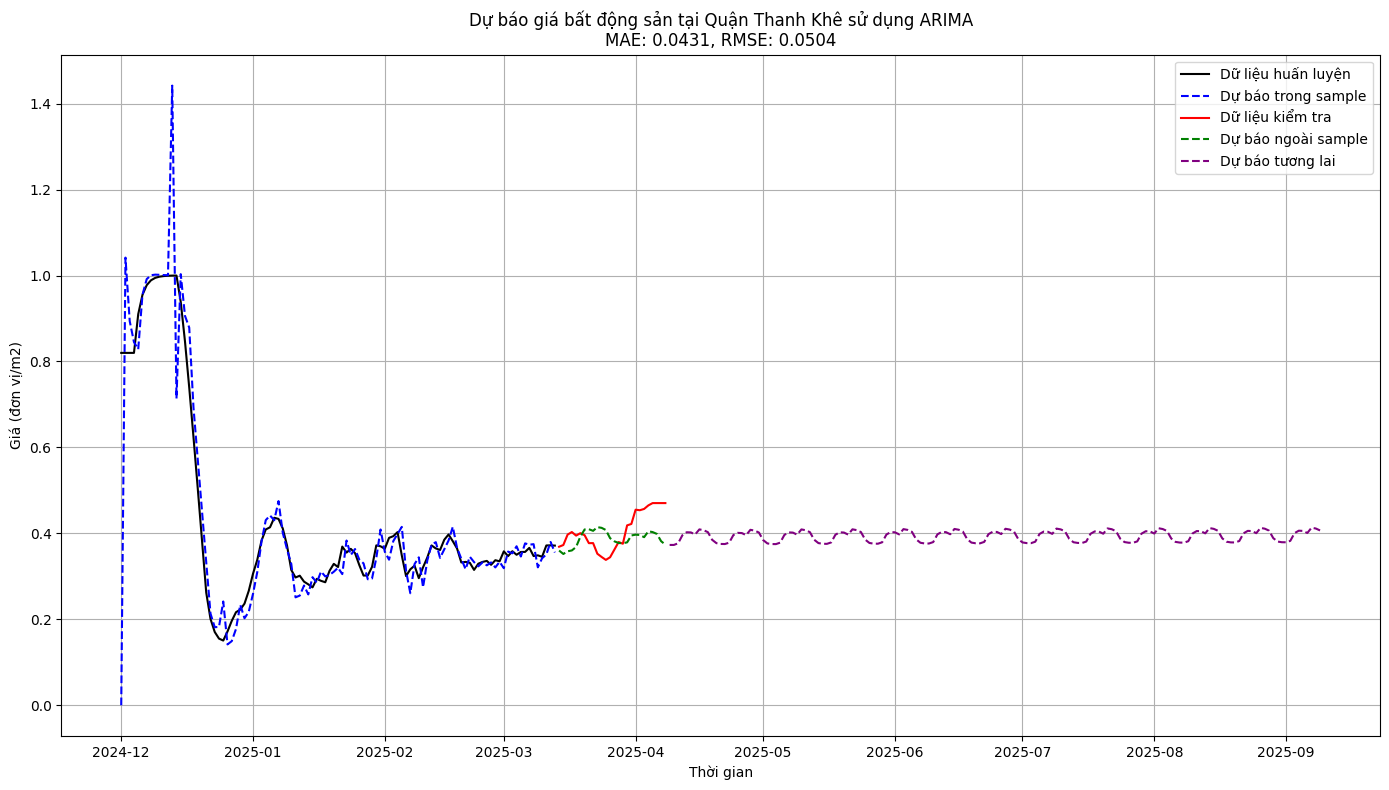

In [19]:
# Bước 14: Vẽ biểu đồ cho từng quận
for district in districts:
    if district in evaluation_results:
        plot_district_forecast(
            district, 
            evaluation_results[district],
            district_datasets[district]
        ).show()

In [20]:
# Bước 15: Dự báo giá trong một khoảng thời gian cho quận cụ thể
def forecast_district_range(district, model_info, start_date, end_date):
    """
    Dự báo giá cho một quận trong một khoảng thời gian cụ thể
    
    Parameters:
    district (str): Tên quận
    model_info (dict): Thông tin về mô hình ARIMA
    start_date (str): Ngày bắt đầu (định dạng 'YYYY-MM-DD')
    end_date (str): Ngày kết thúc (định dạng 'YYYY-MM-DD')
    
    Returns:
    DataFrame: Kết quả dự báo trong khoảng thời gian
    """
    # Chuyển đổi sang datetime
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Tính số ngày cần dự báo
    days = (end - start).days + 1
    
    # Lấy mô hình
    model_results = model_info['model']
    
    # Dự báo
    forecast = model_results.forecast(steps=days)
    
    # Tạo dataframe kết quả
    dates = pd.date_range(start=start, end=end)
    result_df = pd.DataFrame({
        'Ngày': dates,
        'Giá dự báo': forecast[:len(dates)]
    })
    
    # Tính khoảng tin cậy 95% (đây là ước lượng đơn giản)
    forecast_stderr = np.sqrt(model_results.params['sigma2'])
    result_df['Giá thấp nhất (95%)'] = result_df['Giá dự báo'] - 1.96 * forecast_stderr
    result_df['Giá cao nhất (95%)'] = result_df['Giá dự báo'] + 1.96 * forecast_stderr
    
    return result_df

In [21]:
# Bước 16: Ứng dụng: Dự báo giá cho một quận cụ thể trong khoảng thời gian
selected_district = districts[0]  # Thay đổi theo quận bạn muốn dự báo
start_date = '2025-01-01'         # Thay đổi theo nhu cầu
end_date = '2025-03-31'           # Thay đổi theo nhu cầu

forecast_result = forecast_district_range(
    selected_district,
    district_models[selected_district],
    start_date,
    end_date
)

print(f"Dự báo giá cho {selected_district} từ {start_date} đến {end_date}:")
forecast_result.head(10)  # Hiển thị 10 ngày đầu tiên

Dự báo giá cho Huyện Hòa Vang từ 2025-01-01 đến 2025-03-31:


,Ngày,Giá dự báo,Giá thấp nhất (95%),Giá cao nhất (95%)
2025-03-14,2025-01-01,0.052630,0.039787,0.065474
2025-03-15,2025-01-02,0.050663,0.037819,0.063506
2025-03-16,2025-01-03,0.050241,0.037397,0.063085
2025-03-17,2025-01-04,0.050582,0.037738,0.063425
2025-03-18,2025-01-05,0.050350,0.037506,0.063194
2025-03-19,2025-01-06,0.048557,0.035713,0.061400
2025-03-20,2025-01-07,0.050547,0.037704,0.063391
2025-03-21,2025-01-08,0.051400,0.038557,0.064244
2025-03-22,2025-01-09,0.052198,0.039354,0.065041
2025-03-23,2025-01-10,0.055898,0.043054,0.068742


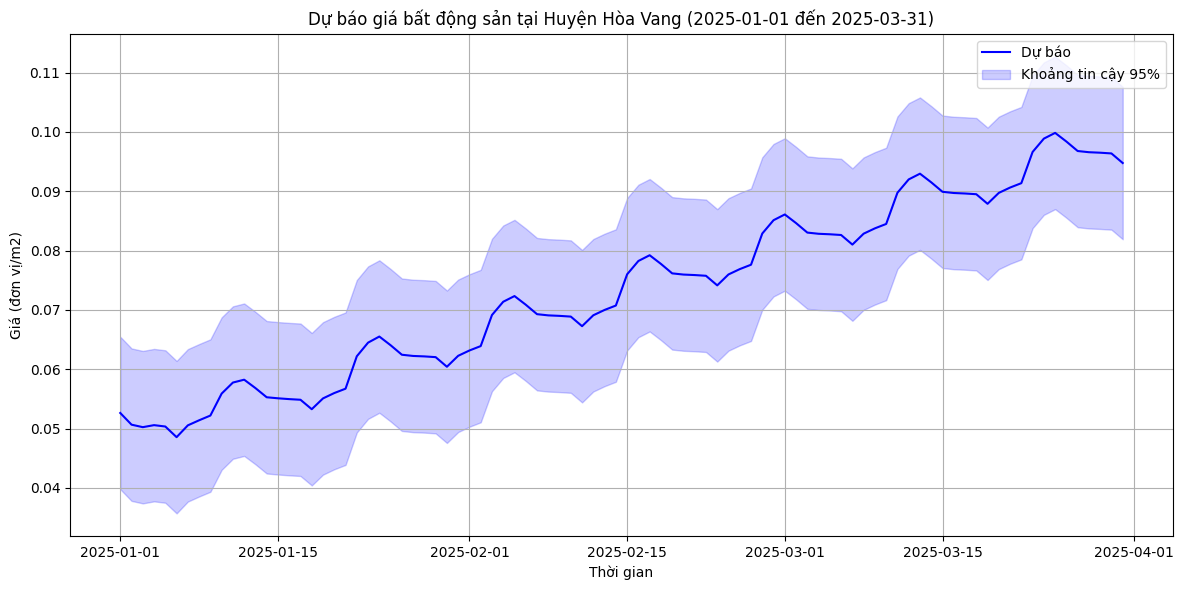

In [22]:
# Bước 17: Vẽ biểu đồ dự báo trong khoảng thời gian
plt.figure(figsize=(12, 6))
plt.plot(forecast_result['Ngày'], forecast_result['Giá dự báo'], color='blue', label='Dự báo')
plt.fill_between(
    forecast_result['Ngày'],
    forecast_result['Giá thấp nhất (95%)'],
    forecast_result['Giá cao nhất (95%)'],
    color='blue',
    alpha=0.2,
    label='Khoảng tin cậy 95%'
)

plt.title(f'Dự báo giá bất động sản tại {selected_district} ({start_date} đến {end_date})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đơn vị/m2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Bước 18: Tạo hàm dự báo cho tất cả các quận trong một khoảng thời gian
def forecast_all_districts(models, start_date, end_date):
    """
    Dự báo giá cho tất cả các quận trong một khoảng thời gian
    
    Parameters:
    models (dict): Dictionary chứa các mô hình đã huấn luyện
    start_date (str): Ngày bắt đầu (định dạng 'YYYY-MM-DD')
    end_date (str): Ngày kết thúc (định dạng 'YYYY-MM-DD')
    
    Returns:
    dict: Kết quả dự báo cho từng quận
    """
    results = {}
    
    for district, model_info in models.items():
        results[district] = forecast_district_range(
            district, model_info, start_date, end_date
        )
    
    return results

In [24]:
# Bước 19: Dự báo cho tất cả quận
all_forecasts = forecast_all_districts(district_models, start_date, end_date)

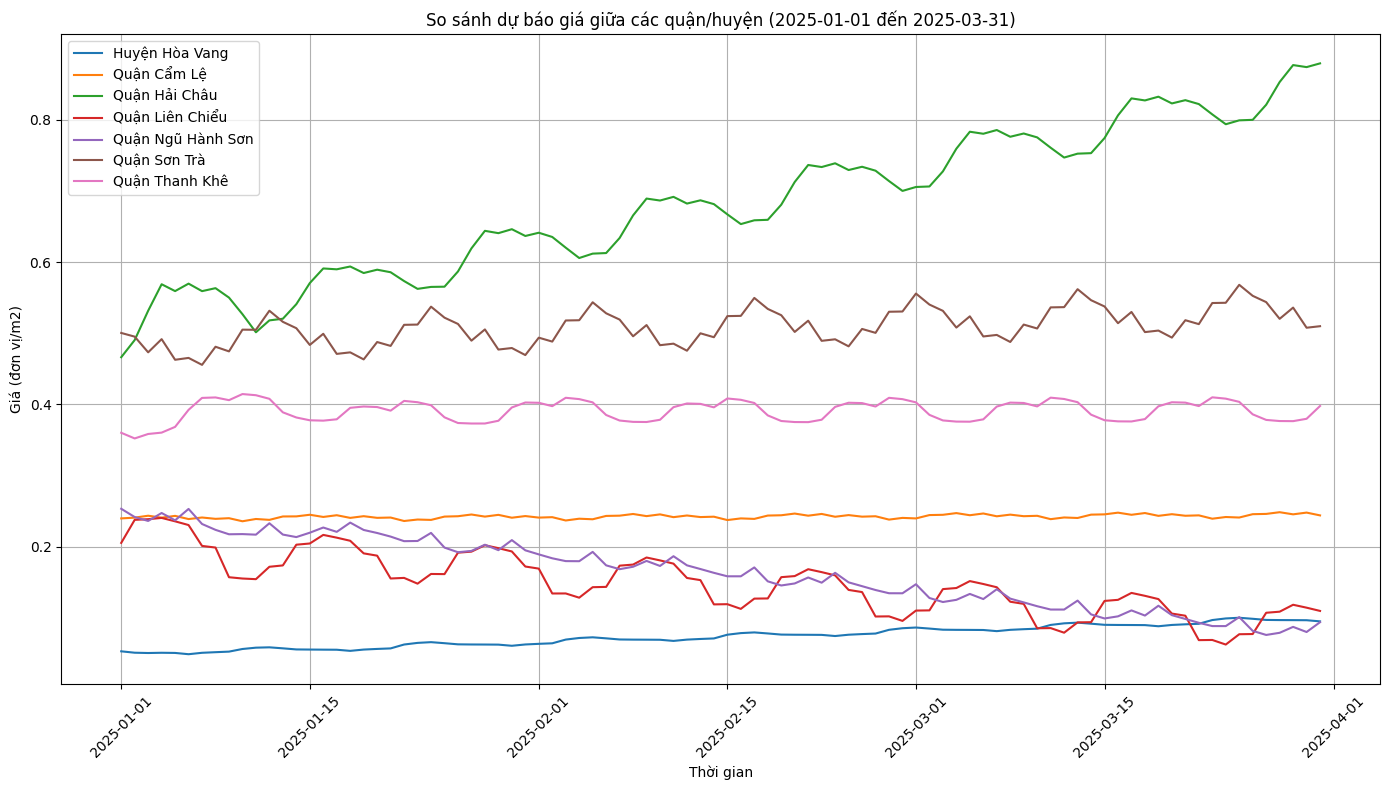

In [25]:
# Bước 20: So sánh dự báo giữa các quận
plt.figure(figsize=(14, 8))

for district, forecast_df in all_forecasts.items():
    plt.plot(forecast_df['Ngày'], forecast_df['Giá dự báo'], label=district)

plt.title(f'So sánh dự báo giá giữa các quận/huyện ({start_date} đến {end_date})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đơn vị/m2)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Bước 22: Lưu mô hình để sử dụng sau này (tùy chọn)
import pickle

# Lưu các mô hình
with open('district_arima_models.pkl', 'wb') as f:
    pickle.dump(district_models, f)

print("Đã lưu mô hình thành công")

Đã lưu mô hình thành công


In [28]:
# Bước 23: So sánh hiệu suất các mô hình qua các quận
# Tạo DataFrame kết quả đánh giá
evaluation_df = pd.DataFrame(columns=['District', 'MAE', 'MSE', 'RMSE', 'ARIMA_order'])

for district, eval_result in evaluation_results.items():
    metrics = eval_result['test_metrics']
    order = district_models[district]['order']
    
    evaluation_df = evaluation_df.append({
        'District': district,
        'MAE': metrics['mae'],
        'MSE': metrics['mse'],
        'RMSE': metrics['rmse'],
        'ARIMA_order': f"({order[0]},{order[1]},{order[2]})"
    }, ignore_index=True)

# Hiển thị kết quả
print("So sánh hiệu suất các mô hình:")
print(evaluation_df)

# Vẽ biểu đồ so sánh RMSE
plt.figure(figsize=(10, 6))
plt.bar(evaluation_df['District'], evaluation_df['RMSE'])
plt.title('So sánh RMSE của các mô hình ARIMA theo quận')
plt.xlabel('Quận/Huyện')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# Bước 24: Hàm tiện ích để dự báo nhanh trong tương lai
def quick_forecast(district, date, models):
    """
    Dự báo nhanh giá cho một quận vào một ngày cụ thể
    
    Parameters:
    district (str): Tên quận
    date (str): Ngày cần dự báo, định dạng 'YYYY-MM-DD'
    models (dict): Dictionary chứa các mô hình đã huấn luyện
    
    Returns:
    dict: Kết quả dự báo
    """
    if district not in models:
        print(f"Không tìm thấy mô hình cho {district}")
        return None
    
    try:
        date_obj = pd.to_datetime(date)
        model_info = models[district]
        model_results = model_info['model']
        
        # Tính số ngày cần dự báo từ cuối tập huấn luyện
        train_end_date = model_results.data.dates[-1]
        days_ahead = (date_obj - train_end_date).days
        
        if days_ahead <= 0:
            print(f"Ngày dự báo phải sau ngày cuối cùng của tập huấn luyện: {train_end_date}")
            return None
        
        # Dự báo
        forecast = model_results.forecast(steps=days_ahead)
        predicted_price = forecast[-1]
        
        # Tính khoảng tin cậy
        forecast_stderr = np.sqrt(model_results.params['sigma2'])
        lower_bound = predicted_price - 1.96 * forecast_stderr
        upper_bound = predicted_price + 1.96 * forecast_stderr
        return {
            'date': date,
            'district': district,
            'predicted_price': predicted_price,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    except Exception as e:
        print(f"Lỗi khi dự báo cho {district} vào ngày {date}: {e}")
        return None
